<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/(On_Google_Colab)_With_Hit_Scoring_TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [3]:
#!pip install modisco

In [4]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [5]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## Grab the input data

In [6]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [7]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [8]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

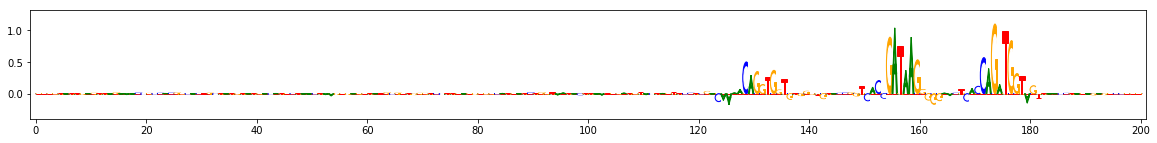

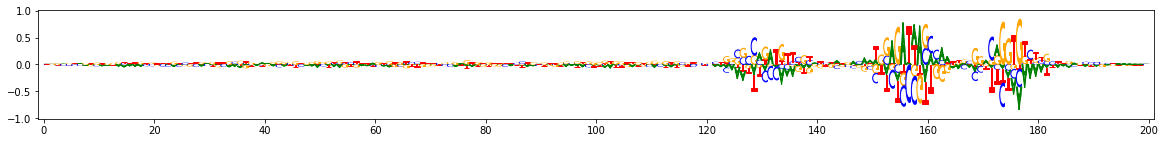

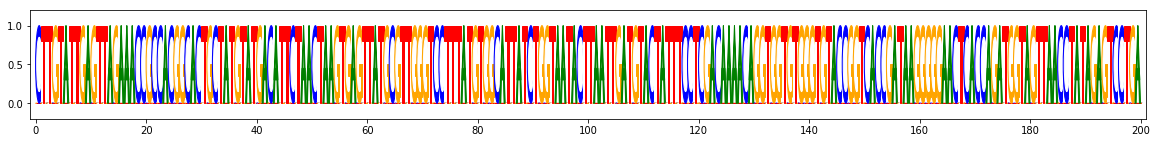

In [9]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.332234752
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Computing threshold
Thresholds from null dist were -1.0124836564064026  and  0.8997364044189453
Final raw thresholds are -1.0124836564064026  and  0.8997364044189453
Final transformed thresholds are -0.8494086021505376  and  0.8402150537634409


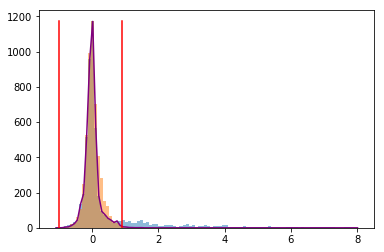

Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025505211204290357
Computing threshold
Thresholds from null dist were -0.918197512626648  and  0.608733057975769
Final raw thresholds are -0.918197512626648  and  0.608733057975769
Final transformed thresholds are -0.9040322580645161  and  0.8833870967741936


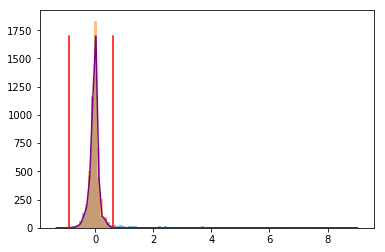

Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.001713569819345139
Computing threshold
Thresholds from null dist were -0.6213091909885406  and  0.6281718015670776
Final raw thresholds are -0.6213091909885406  and  0.6281718015670776
Final transformed thresholds are -0.8680107526881721  and  0.8682795698924731


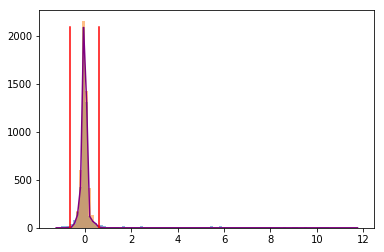

Got 166 coords
After resolving overlaps, got 275 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8402149537634409
MEMORY 0.33787904
275 identified in total
2 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [115, 104]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
MEMORY 0.33787904
On metacluster 1
Metacluster size 104
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)


W1116 15:22:46.934858 4548523456 deprecation_wrapper.py:119] From /Users/avantishrikumar/Research/modisco/modisco/backend/tensorflow_backend.py:87: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 104
(Round 1) Computing coarse affmat
MEMORY 0.332394496
Beginning embedding computation
Computing embeddings


Using TensorFlow backend.
W1116 15:22:48.313807 4548523456 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1116 15:22:48.314695 4548523456 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1116 15:22:48.315608 4548523456 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1116 15:22:48.321037 4548523456 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is depreca

Finished embedding computation in 1.34 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.341389312
Computed nearest neighbors in 0.0 s
MEMORY 0.34156544
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.34156544
Launching nearest neighbors affmat calculation job
MEMORY 0.342888448
Parallel runs completed
MEMORY 0.342634496
Job completed in: 0.45 s
MEMORY 0.342638592
Launching nearest neighbors affmat calculation job
MEMORY 0.342822912
Parallel runs completed
MEMORY 0.342654976
Job completed in: 0.31 s
MEMORY 0.342654976
(Round 1) Computed affinity matrix on nearest neighbors in 0.8 s
MEMORY 0.340975616
Filtered down to 98 of 104
(Round 1) Retained 98 rows out of 104 after filtering
MEMORY 0.34115584
(Round 1) Computing density 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    5.4s


Louvain completed 200 runs in 6.301592826843262 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.2s finished


Wrote graph to binary file in 0.012864112854003906 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.703462
Louvain completed 51 runs in 0.6397759914398193 seconds
Preproc + Louvain took 6.996840000152588 s
Got 7 clusters after round 1
Counts:
{6: 5, 2: 16, 1: 16, 4: 12, 0: 26, 3: 14, 5: 9}
MEMORY 0.341798912
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.341798912
Aggregating for cluster 0 with 26 seqlets
MEMORY 0.341798912
Trimmed 0 out of 26
Skipped 6 seqlets
Aggregating for cluster 1 with 16 seqlets
MEMORY 0.341803008
Trimmed 0 out of 16
Skipped 1 seqlets
Aggregating for cluster 2 with 16 seqlets
MEMORY 0.341803008
Trimmed 1 out of 16
Aggregating for cluster 3 with 14 seqlets
MEMORY 0.341803008
Trimmed 0 out of 14
Skipped 2 seqlets
Aggregating for cluster 4 with 12 seqlets
MEMORY 0.341803008
Trimmed 0 out of 12
Skipped 2 seqlets
Aggregating for cluster 5 with 9 seqlets
MEMORY 0.341803008
Trimmed 0 out of 9
Aggregating for cluster 6 wi

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.259289026260376 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.2s finished


Wrote graph to binary file in 0.010013103485107422 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.715433
After 3 runs, maximum modularity is Q = 0.725825
After 17 runs, maximum modularity is Q = 0.726544
Louvain completed 67 runs in 0.855208158493042 seconds
Preproc + Louvain took 2.164492130279541 s
Got 8 clusters after round 2
Counts:
{0: 26, 5: 9, 1: 15, 7: 2, 2: 12, 4: 10, 3: 10, 6: 2}
MEMORY 0.340762624
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.340762624
Aggregating for cluster 0 with 26 seqlets
MEMORY 0.340762624
Trimmed 5 out of 26
Aggregating for cluster 1 with 15 seqlets
MEMORY 0.340762624
Trimmed 1 out of 15
Aggregating for cluster 2 with 12 seqlets
MEMORY 0.340770816
Trimmed 1 out of 12
Aggregating for cluster 3 with 10 seqlets
MEMORY 0.340779008
Trimmed 0 out of 10
Aggregating for cluster 4 with 10 seqlets
MEMORY 0.340779008
Trimmed 0 out of 10
Aggregating for cluster 5 with 9 seqlets
MEMORY 0.340779008
Trimmed 0 out o

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.4928309917449951 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


Wrote graph to binary file in 0.013262033462524414 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.714045
Louvain completed 51 runs in 0.6757478713989258 seconds
Preproc + Louvain took 2.2239930629730225 s
Got 6 clusters after round 1
Counts:
{4: 16, 2: 23, 3: 17, 0: 25, 1: 25, 5: 3}
MEMORY 0.342908928
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.342908928
Aggregating for cluster 0 with 25 seqlets
MEMORY 0.342908928
Trimmed 0 out of 25
Skipped 3 seqlets
Aggregating for cluster 1 with 25 seqlets
MEMORY 0.342908928
Trimmed 0 out of 25
Skipped 7 seqlets
Aggregating for cluster 2 with 23 seqlets
MEMORY 0.342908928
Trimmed 3 out of 23
Skipped 3 seqlets
Aggregating for cluster 3 with 17 seqlets
MEMORY 0.342908928
Trimmed 0 out of 17
Skipped 2 seqlets
Aggregating for cluster 4 with 16 seqlets
MEMORY 0.342908928
Trimmed 0 out of 16
Skipped 2 seqlets
Aggregating for cluster 5 with 3 seqlets
MEMORY 0.342908928
Trimmed 0 out of 3
(Round 2) num s

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.481076955795288 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


Wrote graph to binary file in 0.011458158493041992 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.74049
After 26 runs, maximum modularity is Q = 0.746432
Louvain completed 76 runs in 0.9465820789337158 seconds
Preproc + Louvain took 2.4769909381866455 s
Got 5 clusters after round 2
Counts:
{3: 16, 4: 14, 2: 16, 0: 26, 1: 16}
MEMORY 0.341970944
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.341970944
Aggregating for cluster 0 with 26 seqlets
MEMORY 0.341970944
Trimmed 0 out of 26
Aggregating for cluster 1 with 16 seqlets
MEMORY 0.341970944
Trimmed 0 out of 16
Aggregating for cluster 2 with 16 seqlets
MEMORY 0.341970944
Trimmed 0 out of 16
Aggregating for cluster 3 with 16 seqlets
MEMORY 0.341970944
Trimmed 0 out of 16
Aggregating for cluster 4 with 14 seqlets
MEMORY 0.341970944
Trimmed 0 out of 14
Got 5 clusters
Splitting into subclusters...
MEMORY 0.341970944
Merging on 5 clusters
MEMORY 0.341970944
On merging iteration 1
Computing pat

In [10]:
import h5py
import numpy as np
%matplotlib inline
import modisco

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0", "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [11]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


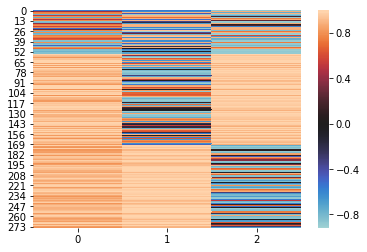

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 85
Task 0 hypothetical scores:


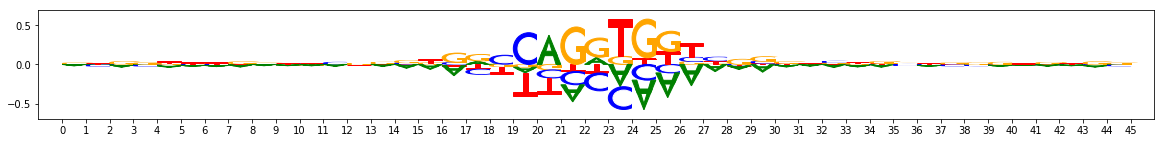

Task 0 actual importance scores:


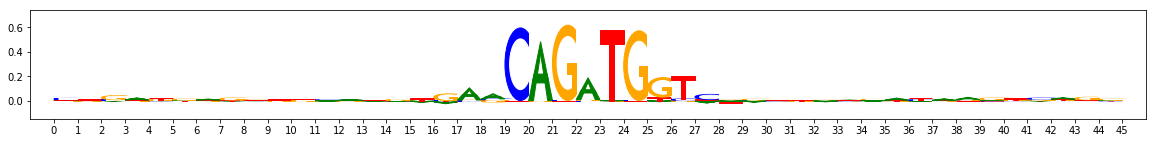

Task 1 hypothetical scores:


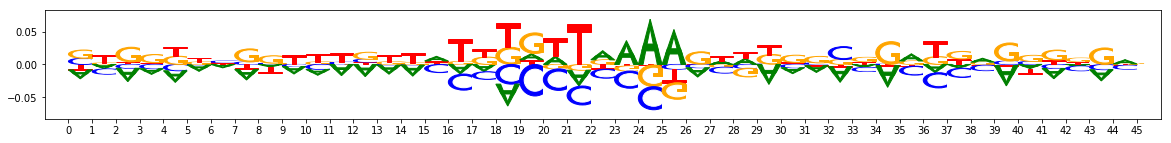

Task 1 actual importance scores:


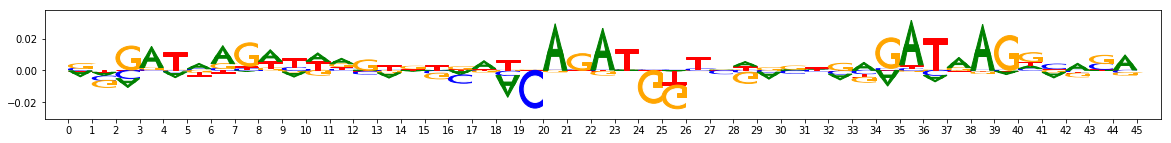

Task 2 hypothetical scores:


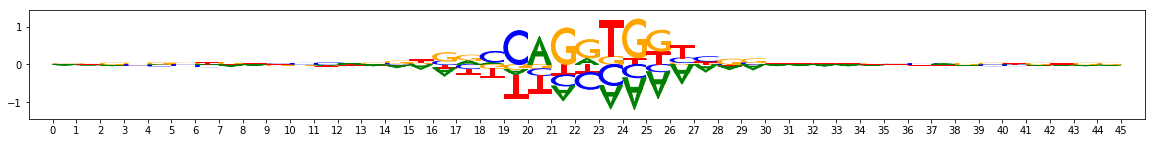

Task 2 actual importance scores:


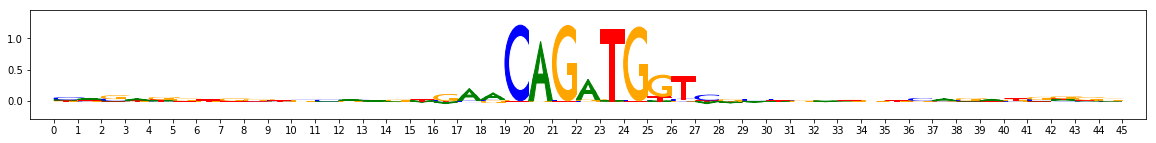

onehot, fwd and rev:


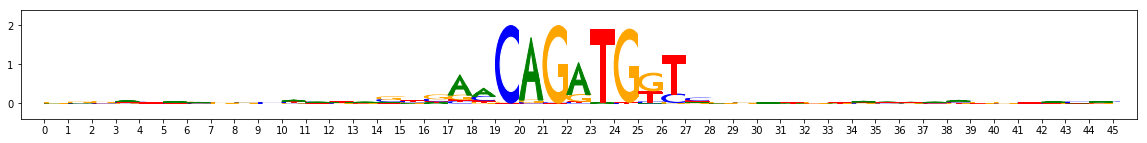

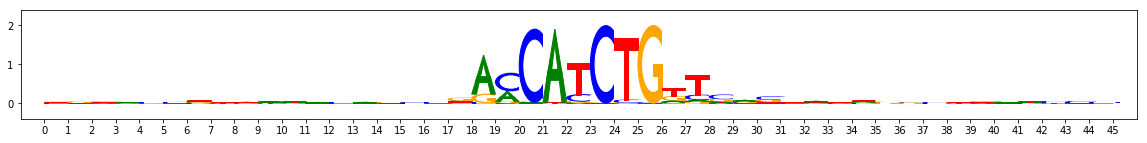

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 67
Task 0 hypothetical scores:


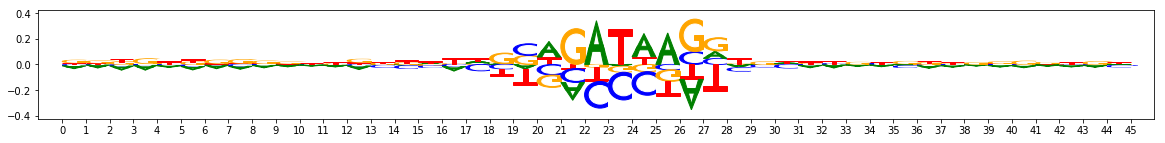

Task 0 actual importance scores:


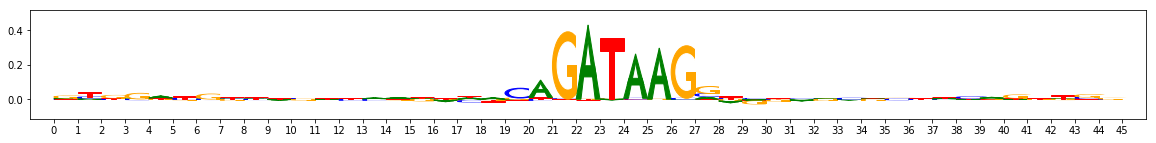

Task 1 hypothetical scores:


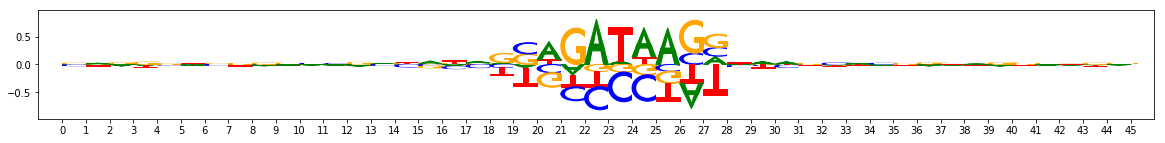

Task 1 actual importance scores:


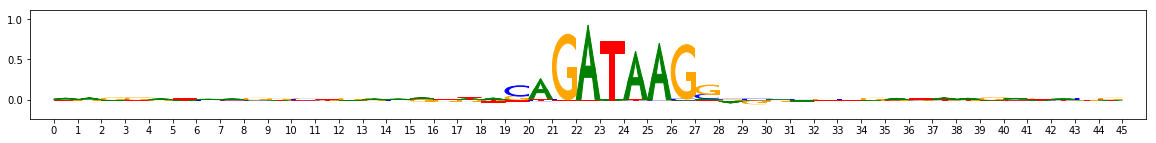

Task 2 hypothetical scores:


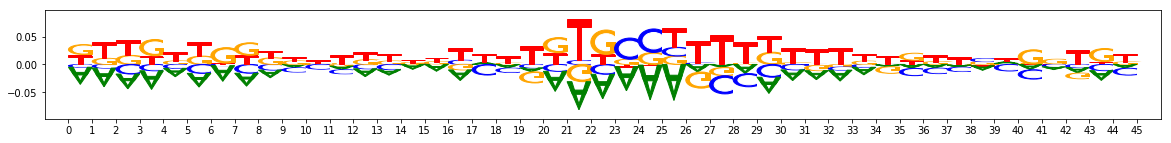

Task 2 actual importance scores:


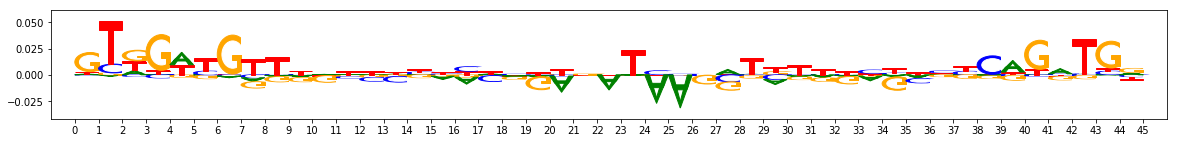

onehot, fwd and rev:


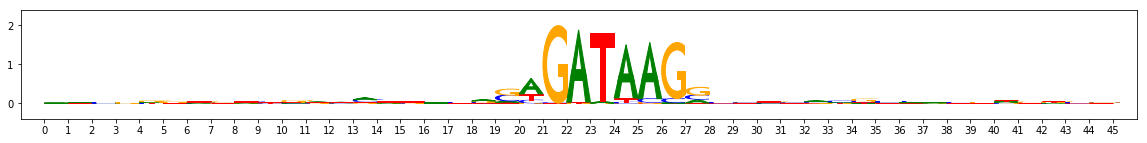

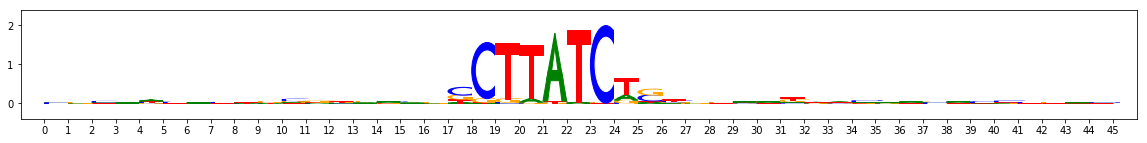

In [12]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [13]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at tag [v0.5.3.1](https://colab.research.google.com/github/kundajelab/tfmodisco/blob/v0.5.3.1/examples/simulated_TAL_GATA_deeplearning/(On_Google_Colab)_With_Hit_Scoring_TF_MoDISco_TAL_GATA.ipynb)

### Trim the motifs by information content

Before scanning the sequence for hits to motifs, it is worth trimming the motifs by their information content. Let's demonstrate scanning for the GATA motif. We will first trim the motif.

Untrimmed Gata - sequence (scaled by information content)


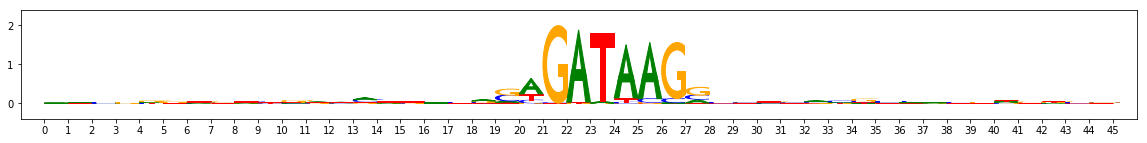

Untrimmed Gata - task 0 hypothetical scores


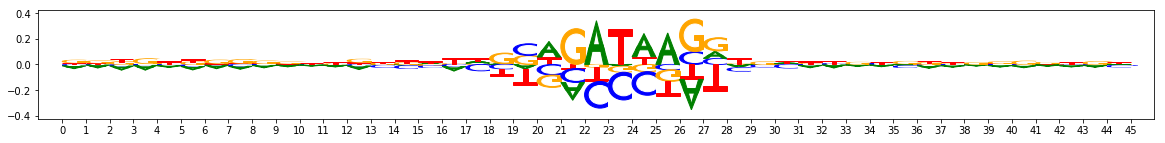

IC-trimmed Gata - sequence (scaled by information content)


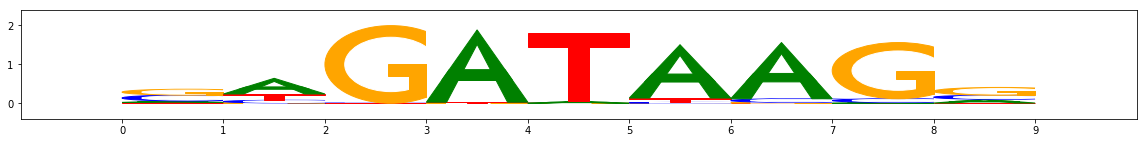

In [14]:
untrimmed_gata_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_1"]
    .seqlets_to_patterns_result.patterns[0])
print("Untrimmed Gata - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_gata_pattern["sequence"].fwd, background=background))
print("Untrimmed Gata - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_gata_pattern["task0_hypothetical_contribs"].fwd)
trimmed_gata = untrimmed_gata_pattern.trim_by_ic(ppm_track_name="sequence",
                                                 background=background,
                                                 threshold=0.3)
print("IC-trimmed Gata - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed_gata["sequence"].fwd, background=background))


Trimming the GATA motif by information content selected the range 19-28 (9bp). Note that the original GATA motif used in the simulation was 10bp long (GATA_disc1 at http://compbio.mit.edu/encode-motifs/ ). Trimming discarded the very first position of that motif, at which there is a weak preference for G followed by A, C and T. Indeed, when we look at the hypothetical importance scores of the untrimmed GATA motif, we see that at position 18 the network has indeed learned a preference for G followed by A, C and T, and that this preference is not apparent when looking at the sequence motif. This reveals an advantage of using the hypothetical importance scores; they reveal the preference of the network even for bases that don't appear frequently. In the future, a more principled approaches to doing the trimming based on the hypothetical importance scores could be developed. For now, we will proceed with the version of the motif that has been trimmed by information content.

### Perform scanning with the trimmed motif

Now that we have the trimmed motif, we will scan the importance score tracks with it. We will compute two kinds of scores described below. The first ("masked hCWM cosine similariy") measures the similarity of the importance scores to the motif, and the second measures the total importance within the window of the motif. Information from both scores will be used to call hits.

#### Masked hCWM cosine similarity

The masked hCWM cosine similarity is used to gauge the similarity between a TF-MoDISco motif and the contribution scores present at a given window of the input sequence, irrespective of the magnitude of the scores. It is best illustrated with an example. Consider the GATA hypothetical contribution weight matrix (hereby referred to as the hCWM) below (the exact values may not be up to date with the rest of the notebook but are meant to be illustrative):
```
>>> print(trimmed_gata["task0_hypothetical_contribs"].fwd)
[[-0.03782349  0.09118378  0.070142   -0.12350229]
 [ 0.1215808  -0.08301942 -0.09632582  0.05776444]
 [-0.1386668  -0.10839121  0.2793305  -0.03227249]
 [ 0.34087033 -0.20777264 -0.02217297 -0.11092472]
 [-0.01404373 -0.21645161 -0.04688007  0.27737541]
 [ 0.1804657  -0.184394   -0.0562734   0.0602017 ]
 [ 0.24564405 -0.04153355 -0.09036025 -0.11375025]
 [-0.23648668  0.09994425  0.25375557 -0.11721314]
 [ 0.05861893  0.04707453  0.10303728 -0.20873074]]
```

Imagine we wanted to use this to score the sequence `CCGATTCGG`. We could take the cosine similarity between the GATA hCWM and the hypothetical importance scores at `CCGATTCGG`. Empirically, however, we have found that over-reliance on hypothetical importance scores - without grounding in the bases that are actually present in the sequence - can yield false positives. We could take the cosine similarity between the GATA hCWM and the actual contribution scores at `CCGATTCGG`, but this is an unsatisfactory solution because the actual contribution scores at `CCGATTCGG` only have nonzero values at the bases that are actually present at each position in the sequence, whereas the GATA hCWM has nonzero values for all bases at all positions. Our solution is instead to *mask* the hCWM to only consider the bases corresponding to `CCGATTCGG`. Concretely, when scannign the sequence `CCGATTCGG`, we consider the following masked hCWM:

```
[[ 0.0         0.09118378  0.0         0.0       ]
 [ 0.0        -0.08301942  0.0         0.0       ]
 [ 0.0         0.0         0.2793305   0.0       ]
 [ 0.34087033  0.0         0.0         0.0       ]
 [ 0.0         0.0         0.0         0.27737541]
 [ 0.0         0.0         0.0         0.0602017 ]
 [ 0.0        -0.04153355  0.0         0.0       ]
 [ 0.0         0.0         0.25375557  0.0       ]
 [ 0.0         0.0         0.10303728  0.0       ]]
```
Our similarity score for `CCGATTCGG` will then be the cosine similarity between the masked hCWM above and the contribution scores present at `CCGATTCGG`. The masking is done separately for each window scanned. You can refer to the code for how this is achieved efficiently using numpy stride tricks.

#### Sum of scores in window

This simply consists of taking the sum of the contribution scores in a given window of the input sequence. Looking at the total contribution is useful for filtering out motif hits that may look like a good match if you only considered the local sequence, but which are not in fact bound by the TF because the sequence does not have the requisite cofactor motifs. For example, imagine both TAL and GATA need to be present in order for either TF to bind (this logic is encapsulated in prediction task 0 in the simulation, which is a 1 iff both TAL and GATA are present, and a 0 otherwise). Even though a given portion of the sequence may be an excellent match to the GATA motif, we may not want to consider it a motif hit if the TAL motif is not also present in the surrounding sequence. The idea is that the neural network will have learned this logic and will give GATA motifs less importance for task 0 if they are present in a sequence that does not also have TAL.
